# From PyTorch to Neural Posterior Estimation

In this notebook, we'll build up to **Neural Posterior Estimation (NPE)** step by step:

1. **Part 1: PyTorch Primer** - The building blocks of deep learning
2. **Part 2: The Inverse Problem** - Why we need distributions, not point estimates
3. **Part 3: Neural Posterior Estimation** - Learning to approximate the posterior

We'll use a simple 1D example throughout to build intuition.

In [1]:
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(42);

---
## Part 1: PyTorch Primer

Before we dive into NPE, let's review the **5 key ingredients** of deep learning in PyTorch:

1. A **dataset**
2. A **neural network**
3. A **loss function**
4. An **optimizer**
5. A **training loop**

### Our Running Example

We have a simulator that generates data:
$$x = f(\theta) + \epsilon = \theta + 0.3\sin(2\pi\theta) + \epsilon$$

where $\theta \sim \mathcal{U}(0,1)$ is our parameter and $\epsilon \sim \mathcal{N}(0, 0.05)$ is noise.

Think of this as a tiny "simulator" - given a parameter $\theta$, it produces an observation $x$.

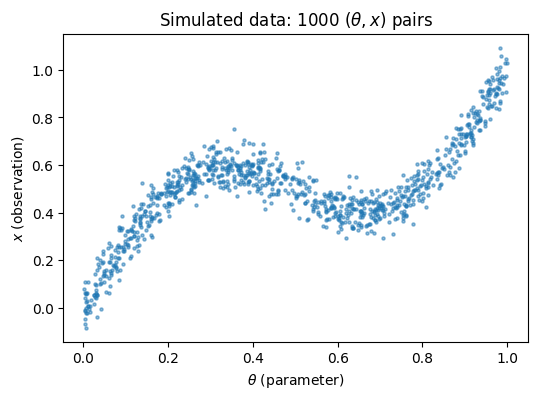

In [2]:
# Generate data: simulate many (theta, x) pairs
n_samples = 1000
theta = torch.rand((n_samples, 1))  # prior samples
noise = torch.randn((n_samples, 1)) * 0.05
x = theta + 0.3 * torch.sin(2 * math.pi * theta) + noise  # simulated observations

# Visualize
plt.figure(figsize=(6, 4))
plt.scatter(theta, x, s=5, alpha=0.5)
plt.xlabel(r"$\theta$ (parameter)")
plt.ylabel(r"$x$ (observation)")
plt.title("Simulated data: 1000 $(\\theta, x)$ pairs")
plt.show()

### Ingredient 1: Dataset

PyTorch provides `TensorDataset` and `DataLoader` to handle batching and shuffling.

In [3]:
# Wrap data in a Dataset and DataLoader
dataset = TensorDataset(theta, x)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Example: get one batch
theta_batch, x_batch = next(iter(dataloader))
print(f"Batch shapes: theta={theta_batch.shape}, x={x_batch.shape}")

Batch shapes: theta=torch.Size([64, 1]), x=torch.Size([64, 1])


### Ingredient 2: Neural Network

We define a simple feedforward network using `nn.Sequential`.

In [4]:
# Simple network: input (1D) -> hidden -> hidden -> output (1D)
net = nn.Sequential(
    nn.Linear(1, 32),   # input -> hidden
    nn.ReLU(),          # activation
    nn.Linear(32, 32),  # hidden -> hidden
    nn.ReLU(),          # activation
    nn.Linear(32, 1),   # hidden -> output
)

print(net)

Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
)


### Ingredient 3: Loss Function

For regression, we use **Mean Squared Error (MSE)**:
$$\mathcal{L} = \frac{1}{N}\sum_i (\hat{x}_i - x_i)^2$$

In [5]:
def mse_loss(prediction, target):
    return torch.mean((prediction - target) ** 2)

### Ingredient 4: Optimizer

The optimizer updates the network weights to minimize the loss. **Adam** is a good default.

In [6]:
optimizer = Adam(net.parameters(), lr=0.01)

### Ingredient 5: Training Loop

The training loop ties everything together:
```
for each epoch:
    for each batch:
        1. Forward pass: compute predictions
        2. Compute loss
        3. Backward pass: compute gradients
        4. Update weights
```

In [7]:
# Train: predict x from theta (the FORWARD direction)
losses = []
for epoch in range(200):
    for theta_batch, x_batch in dataloader:
        optimizer.zero_grad()           # Reset gradients
        prediction = net(theta_batch)   # Forward pass: theta -> x
        loss = mse_loss(prediction, x_batch)  # Compare to true x
        loss.backward()                 # Backward pass
        optimizer.step()                # Update weights
        losses.append(loss.item())

print(f"Final loss: {losses[-1]:.4f}")

Final loss: 0.0042


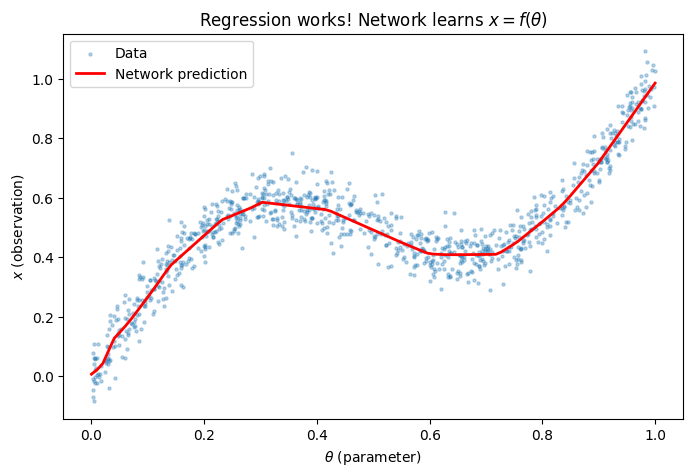

The network learned to predict the MEAN of x given theta.


In [8]:
# Visualize what the network learned
theta_test = torch.linspace(0, 1, 100).unsqueeze(1)
with torch.no_grad():
    x_pred = net(theta_test)

plt.figure(figsize=(8, 5))
plt.scatter(theta, x, s=5, alpha=0.3, label="Data")
plt.plot(theta_test, x_pred, "r-", linewidth=2, label="Network prediction")
plt.xlabel(r"$\theta$ (parameter)")
plt.ylabel(r"$x$ (observation)")
plt.title(r"Regression works! Network learns $x = f(\theta)$")
plt.legend()
plt.show()

print("The network learned to predict the MEAN of x given theta.")

### Part 1 Summary: The 5 Ingredients

| Ingredient | What it does |
|------------|-------------|
| **Dataset** | Stores and batches your data |
| **Network** | Maps inputs to outputs |
| **Loss** | Measures prediction error |
| **Optimizer** | Updates weights to reduce loss |
| **Training loop** | Iterates until convergence |

We trained a network to predict $x$ from $\theta$ (the **forward** direction). This works well!

But for **inference**, we need the opposite: given an observation $x$, what parameter $\theta$ generated it?

---
## Part 2: The Inverse Problem

Above, we used NNs in PyTorch to predict $x$ from $\theta$. But for SBI, we need the **inverse**: given $x$, what is $\theta$?

Let's visualize what happens when we flip the axes:

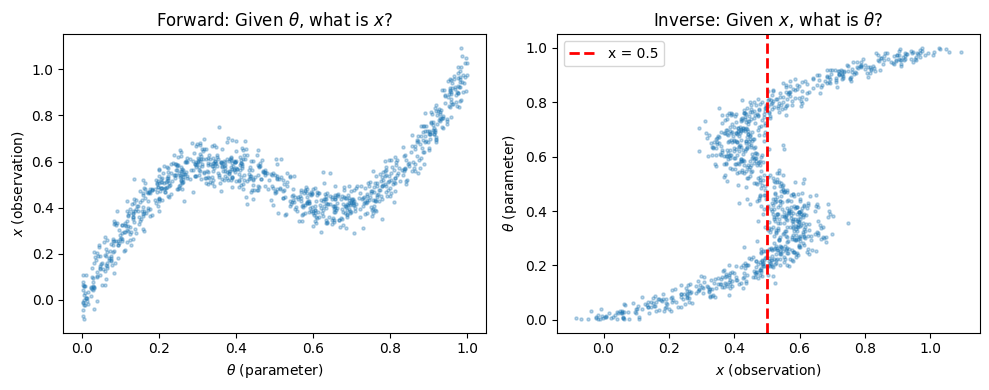

In [9]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(theta, x, s=5, alpha=0.3)
plt.xlabel(r"$\theta$ (parameter)")
plt.ylabel(r"$x$ (observation)")
plt.title(r"Forward: Given $\theta$, what is $x$?")

plt.subplot(1, 2, 2)
plt.scatter(x, theta, s=5, alpha=0.3)
plt.xlabel(r"$x$ (observation)")
plt.ylabel(r"$\theta$ (parameter)")
plt.axvline(0.5, color="red", linestyle="--", linewidth=2, label="x = 0.5")
plt.title(r"Inverse: Given $x$, what is $\theta$?")
plt.legend()

plt.tight_layout()
plt.show()

### Think First!

Look at the right plot above. Notice how the same data looks different when we swap the axes!

- **Left (forward)**: Each $\theta$ maps to roughly one $x$ value → well-defined function
- **Right (inverse)**: Some $x$ values (like $x \approx 0.5$) correspond to **multiple** $\theta$ values!

For $x = 0.5$, can you give a single "best" value for $\theta$?

<details>
<summary>Click to reveal answer</summary>

**No!** Multiple $\theta$ values could have generated $x = 0.5$. The inverse problem is **ambiguous** - we need a **distribution** over $\theta$, not a single point estimate.

This is exactly what the **posterior** $p(\theta|x)$ gives us!
</details>

### We Need a Distribution!

A simple regression network outputs one number. But we need a **distribution** over $\theta$.

**Key idea**: Instead of predicting a single value, predict the **parameters of a distribution**.

For a Gaussian posterior approximation:
$$q(\theta|x) = \mathcal{N}(\theta; \mu(x), \sigma(x))$$

The network takes $x$ as input and outputs $(\mu, \sigma)$ - the parameters that define the distribution.

<img src="figures/nn.png" width="700">

*The network outputs distribution parameters ($\mu$, $\sigma$), not a point estimate. The loss function encourages the predicted distribution to assign high probability to the true $\theta$.*

### Think First!

If our network outputs $(\mu, \sigma)$ for a Gaussian, what should the **output dimension** be?

- A) 1 (just the mean)
- B) 2 (mean and standard deviation)
- C) 3 (mean, standard deviation, and something else)

<details>
<summary>Click to reveal answer</summary>

**B) 2** - We need both $\mu$ and $\sigma$ to fully specify a Gaussian distribution.

In practice, we output $\log(\sigma^2)$ instead of $\sigma$ for numerical stability (it can be any real number, while $\sigma$ must be positive).
</details>

### The Training Objective

How do we train a network to output good distribution parameters?

We want the predicted distribution $q(\theta|x)$ to assign **high probability** to the true $\theta$ values in our training data.

**Loss function**: Negative Log-Likelihood (NLL)
$$\mathcal{L} = -\frac{1}{N}\sum_i \log q(\theta_i | x_i)$$

Minimizing this is equivalent to **maximizing the probability** of the training data under our predicted distribution.

### Exercise: Understanding the Loss

The log-probability of $\theta$ under a Gaussian $\mathcal{N}(\mu, \sigma)$ is:
$$\log \mathcal{N}(\theta; \mu, \sigma) = -\frac{1}{2}\left(\log(2\pi) + \log(\sigma^2) + \frac{(\theta-\mu)^2}{\sigma^2}\right)$$

**Question**: What happens to the loss when...

1. $\mu$ is far from the true $\theta$?
2. $\sigma$ is very small but $\mu \neq \theta$?
3. $\sigma$ is very large?

<details>
<summary>Click to reveal answers</summary>

1. **$\mu$ far from $\theta$**: The $(\theta-\mu)^2$ term becomes large → loss increases → network learns to move $\mu$ closer to $\theta$

2. **$\sigma$ small but wrong $\mu$**: Double penalty! Small $\sigma^2$ in denominator makes $(\theta-\mu)^2/\sigma^2$ huge → network learns it can't be overconfident when wrong

3. **$\sigma$ large**: The $\log(\sigma^2)$ term increases the loss → network learns not to be too uncertain (lazy)

The loss balances accuracy ($\mu$ close to $\theta$) with calibrated uncertainty ($\sigma$ matching true spread)!
</details>

### Exercise: Building the Posterior Network

Now it's your turn! Complete the network below that outputs distribution parameters.

**Your task**: Fill in the `???` to make the output layer produce both $\mu$ and $\log\sigma^2$ for each parameter dimension.

**Hint**: If `theta_dim = 2`, how many outputs do you need?

In [14]:
# TODO: Complete this class!

class PosteriorNet(nn.Module):
    """Network that predicts posterior distribution parameters.

    Input: observation x (shape: batch_size x x_dim)
    Output: parameters (mu, log_var) of Gaussian q(theta|x)
    """

    def __init__(self, x_dim, theta_dim, hidden_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(x_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, theta_dim * 2),  # TODO: What should the output dimension be?
        )
        self.theta_dim = theta_dim

    def forward(self, x):
        """Returns (mu, log_var) for the predicted posterior."""
        out = self.net(x)
        mu = out[:, :self.theta_dim]
        log_var = out[:, self.theta_dim:]  # log(sigma^2) for numerical stability
        return mu, log_var  # TODO: what to return here?

### Solution

Run the cell below to load the solution (or try completing it yourself first!):

In [17]:
# %load solutions/solutions_nb_2b.py
"""Solutions for Notebook 02: Neural Posterior Estimation"""

# Solution for PosteriorNet output dimension
# The key insight: we need TWO numbers per parameter dimension
# - mu (mean of the Gaussian)
# - log_var (log variance for numerical stability)
#
# So output_dim = theta_dim * 2

class PosteriorNet(nn.Module):
    """Network that predicts posterior distribution parameters.

    Input: observation x (shape: batch_size x x_dim)
    Output: parameters (mu, log_var) of Gaussian q(theta|x)
    """

    def __init__(self, x_dim, theta_dim, hidden_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(x_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, theta_dim * 2),  # <- KEY: output mu AND log_var
        )
        self.theta_dim = theta_dim

    def forward(self, x):
        """Returns (mu, log_var) for the predicted posterior."""
        out = self.net(x)
        mu = out[:, :self.theta_dim]
        log_var = out[:, self.theta_dim:]
        return mu, log_var

    def log_prob(self, theta, x):
        """Compute log q(theta | x) under the predicted Gaussian."""
        mu, log_var = self.forward(x)
        log_prob = -0.5 * (math.log(2 * math.pi) + log_var + (theta - mu)**2 / torch.exp(log_var))
        return log_prob.sum(dim=-1)


### Part 2 Summary

- The inverse problem requires a **distribution**, not a point estimate
- We use a neural network to predict **distribution parameters** $(\mu, \sigma)$
- Training objective: **negative log-likelihood** - make the predicted distribution assign high probability to true $\theta$ values

This is the core idea of **Neural Posterior Estimation (NPE)**!

---
## Part 3: Neural Posterior Estimation in Action

Let's train our posterior network and see what it learns!

**Your task**: Complete the code by including the loss function to train the posterior network.

In [18]:
# Create and train the posterior network
posterior_net = PosteriorNet(x_dim=1, theta_dim=1)
optimizer = Adam(posterior_net.parameters(), lr=0.01)

losses = []
for epoch in range(200):
    for theta_batch, x_batch in dataloader:
        optimizer.zero_grad()

        # Compute log probability of true theta under predicted posterior
        log_prob = posterior_net.log_prob(theta_batch, x_batch)

        # Loss = negative log likelihood
        loss = -log_prob.mean()

        loss.backward()
        optimizer.step()
        losses.append(loss.item())

print(f"Final NLL: {losses[-1]:.4f}")

AttributeError: 'PosteriorNet' object has no attribute 'log_prob'

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(losses)
plt.xlabel("Training step")
plt.ylabel("Negative Log-Likelihood")
plt.title("Training Progress")
plt.show()

### Visualizing the Learned Posteriors

Let's see what posterior distributions the network predicts for different observations:

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

x_values = [0.3, 0.5, 0.8]
theta_range = torch.linspace(0, 1, 200)

for ax, x_obs in zip(axes, x_values):
    # Get posterior parameters from network
    x_tensor = torch.tensor([[x_obs]])
    with torch.no_grad():
        mu, log_var = posterior_net(x_tensor)
        sigma = torch.exp(0.5 * log_var)

    # Plot the Gaussian posterior
    posterior = torch.exp(-0.5 * ((theta_range - mu) / sigma)**2) / (sigma * math.sqrt(2 * math.pi))
    ax.plot(theta_range, posterior.squeeze(), "b-", linewidth=2)
    ax.fill_between(theta_range, 0, posterior.squeeze(), alpha=0.3)
    ax.axvline(mu.item(), color="red", linestyle="--", label=f"$\\mu$={mu.item():.2f}")
    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel(r"$q(\theta|x)$")
    ax.set_title(f"Posterior for x = {x_obs}")
    ax.legend()
    ax.set_xlim(0, 1)

plt.tight_layout()
plt.show()

In [ ]:
# Overlay posteriors on the data
plt.figure(figsize=(8, 6))
plt.scatter(x, theta, s=5, alpha=0.2, label="Training data")

# Show posteriors for several x values
for x_obs in [0.2, 0.4, 0.6, 0.8, 1.0]:
    x_tensor = torch.tensor([[x_obs]])
    with torch.no_grad():
        mu, log_var = posterior_net(x_tensor)
        sigma = torch.exp(0.5 * log_var)

    # Plot posterior as horizontal Gaussian
    theta_range = torch.linspace(0, 1, 100)
    posterior = torch.exp(-0.5 * ((theta_range - mu) / sigma)**2)
    plt.plot(x_obs + posterior.squeeze() * 0.1, theta_range, "r-", linewidth=1.5)

plt.xlabel(r"$x$ (observation)")
plt.ylabel(r"$\theta$ (parameter)")
plt.title(r"NPE: Learned Posterior $q(\theta|x)$")
plt.plot([], [], "r-", linewidth=2, label="Predicted posteriors")
plt.legend()
plt.show()

print("Red curves show the posterior distribution for different observations.")
print("The network learned to output appropriate (mu, sigma) for each x!")

### Quick Check: What Did the Network Learn?

Let's verify that the network outputs different distribution parameters for different inputs:

In [ ]:
print("Network outputs for different observations:")
print("-" * 40)
for x_obs in [0.2, 0.5, 0.8, 1.1]:
    x_tensor = torch.tensor([[x_obs]])
    with torch.no_grad():
        mu, log_var = posterior_net(x_tensor)
        sigma = torch.exp(0.5 * log_var)
    print(f"x = {x_obs:.1f}  →  mu = {mu.item():.3f}, sigma = {sigma.item():.3f}")

### The Power of Amortization

Notice something important: we can get posteriors for **any** observation instantly!

This is called **amortization** - we pay the cost of training once, then inference is instant.

### Limitations of Gaussian Posteriors

Our simple Gaussian approximation has limitations:

1. **Can't capture multi-modality**: What if two different $\theta$ values could equally explain an observation? A single Gaussian can't represent this.

2. **Limited shape**: Real posteriors can be skewed, heavy-tailed, or have complex correlations.

**Solutions** (covered in Session 3):
- **Mixture Density Networks**: Output parameters for multiple Gaussians
- **Normalizing Flows**: Flexible distributions that can model any shape
- **The `sbi` package**: Implements these advanced methods with a simple API!

<img src="figures/npe_illustration.png" width="600">

*A Mixture Density Network outputs mixing coefficients ($\alpha$), means ($\mu$), and standard deviations ($\sigma$) for multiple Gaussian components, allowing it to represent multi-modal posteriors.*

---
## Summary

### The NPE Recipe

1. **Generate training data**: Sample $\theta \sim p(\theta)$, simulate $x \sim p(x|\theta)$
2. **Train a neural network**: Learn to predict distribution parameters from $x$
3. **Loss function**: Negative log-likelihood $-\log q_\phi(\theta|x)$
4. **At inference**: Just run the network on your observation!

### Key Equations

**Posterior approximation** (Gaussian):
$$q_\phi(\theta|x) = \mathcal{N}(\theta; \mu_\phi(x), \sigma_\phi(x))$$

**Training objective**:
$$\mathcal{L} = -\mathbb{E}_{p(\theta, x)}[\log q_\phi(\theta|x)]$$

### What's Next?

In **Session 3**, we'll:
- Apply NPE to the Lotka-Volterra model from Session 2
- Use the `sbi` package with flexible normalizing flow posteriors
- Learn about the full SBI workflow including validation and diagnostics

## Learning Goals Checklist

After this notebook, you should be able to:

- [ ] Name the 5 key ingredients of PyTorch training
- [ ] Explain why the inverse problem requires a distribution, not a point estimate
- [ ] Describe what a posterior network outputs (distribution parameters)
- [ ] Explain the negative log-likelihood loss and what it encourages
- [ ] Define "amortization" and why it makes NPE efficient